<h1><center>Assignment 9: AUTHOR CLASSIFICATION </center></h1>

## Preprocess text and explore data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

In [6]:
from nltk.corpus import gutenberg, words

print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [7]:
import re
authors, novels = [], []
# get the author's name and novel
for fileid in gutenberg.fileids():
    # get the author
    author = re.compile('(?P<before>.+)-').search(fileid).group('before')
    #get the novel
    novel = re.compile('-(?P<after>.+)').search(fileid).group('after')
    novel = novel.replace('.txt', '')
    
    authors.append(author)
    novels.append(novel)

In [8]:
# clean data

In [9]:
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')
list_word = []
for fileid in gutenberg.fileids():
    # convert to lower case 
    lower = [word.lower() for word in gutenberg.words(fileid)]
    
    # remove number and punctuation and stop words
    remove = [word for word in lower if word.isalpha() == True and word not in stopwords_list]
    
    # remove authors
    remove_authors = [word for word in remove if word not in np.unique(authors)]
    
    list_word.append(remove_authors)

In [10]:
# split each documents into different samples

def split_sample(df, num_sam):
    df_temp = df.copy(deep=True)   
    df_temp['Texts'] = df_temp['Texts'].apply(lambda x: ' '.join(x))
    df_temp['Texts'] = df_temp['Texts'].apply(lambda x: textwrap.wrap(x, len(x)/num_sam))
    df_temp['Texts'] = df_temp['Texts'].apply(lambda x: ','.join(x))
    df_new = pd.concat([pd.DataFrame({'Novels': row['Novels'], 'Texts' : row['Texts'].split(','), 
                                      'Authors': row['Authors'],'Target': row['Target']}) 
                                      for _, row in df_temp.iterrows()]).reset_index(drop=True)
    
    return df_new

In [11]:
from sklearn.preprocessing import LabelEncoder
import textwrap
le = LabelEncoder()

# create dataframe
df = pd.DataFrame(data={'Novels': novels, 'Texts': list_word, 'Authors': authors})
df['Target'] = le.fit_transform(df['Authors'])

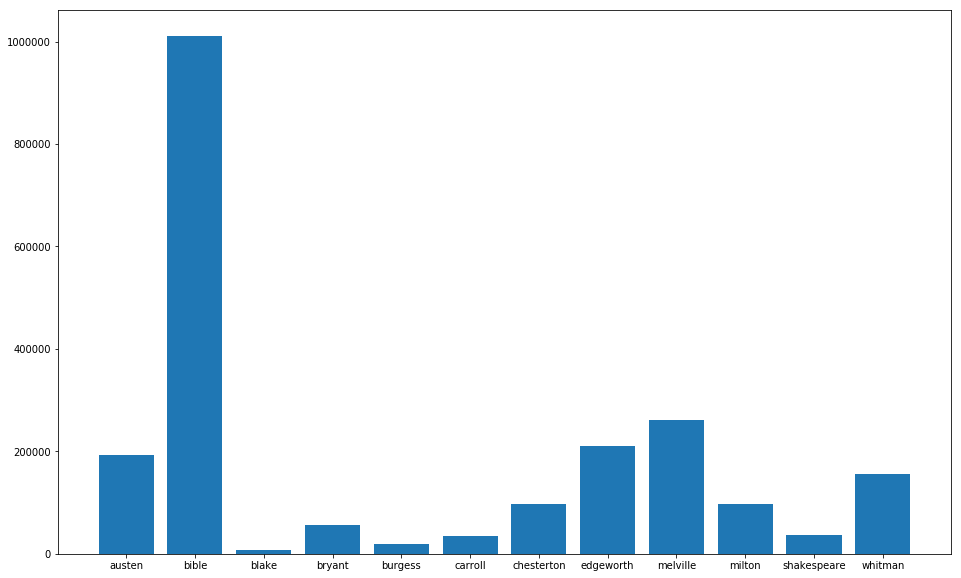

In [12]:
# word counts by authors

doc_len = [len(gutenberg.words(fileid)) for fileid in gutenberg.fileids()]

plt.figure(figsize=(16,10))
plt.bar(authors, doc_len);

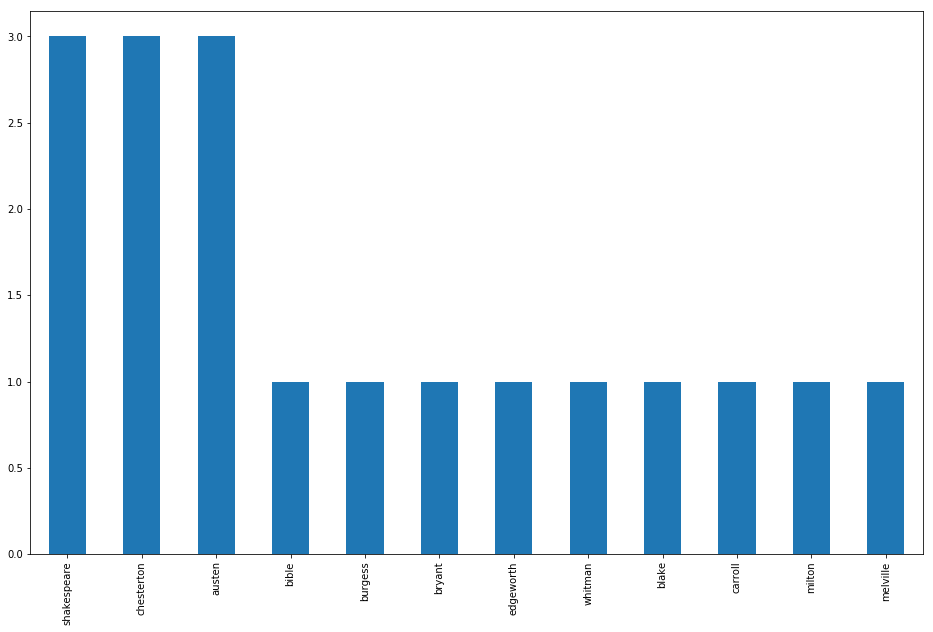

In [13]:
# document counts by authors

plt.figure(figsize=(16,10))
df.Authors.value_counts().plot(kind='bar');

In [14]:
# split each document in to 40 different texts
df_new = split_sample(df, 40)

In [15]:
# before splitting

In [16]:
df

,Novels,Texts,Authors,Target
0,emma,"[emma, jane, volume, chapter, emma, woodhouse,...",austen,0
1,persuasion,"[persuasion, jane, chapter, sir, walter, ellio...",austen,0
2,sense,"[sense, sensibility, jane, chapter, family, da...",austen,0
3,kjv,"[king, james, old, testament, king, james, fir...",bible,1
4,poems,"[poems, william, songs, innocence, experience,...",blake,2
5,stories,"[stories, tell, children, sara, cone, two, lit...",bryant,3
6,busterbrown,"[adventures, buster, bear, thornton, w, buster...",burgess,4
7,alice,"[alice, adventures, wonderland, lewis, chapter...",carroll,5
8,ball,"[ball, cross, g, k, discussion, somewhat, air,...",chesterton,6
9,brown,"[wisdom, father, brown, g, k, absence, mr, gla...",chesterton,6


In [17]:
# after splitting

In [18]:
df_new

,Novels,Texts,Authors,Target
0,emma,emma jane volume chapter emma woodhouse handso...,austen,0
1,emma,purchase randalls sale randalls long looked fo...,austen,0
2,emma,wife lived together appeared mr martin bore pa...,austen,0
3,emma,little faults excellent creature shall see bet...,austen,0
4,emma,propriety requires present unbidden mind persu...,austen,0
...,...,...,...,...
733,leaves,uttering gladness eyes soul seeing perfection ...,whitman,11
734,leaves,shelter grass innocent golden calm dawn spring...,whitman,11
735,leaves,metaphysics onward onward speeding slowly sure...,whitman,11
736,leaves,take open take deepest freest waters pending y...,whitman,11


In [19]:
# word_frequency

from nltk import FreqDist
import nltk

dictionary = [word for doc in list_word for word in doc]
freqdist = FreqDist(dictionary)

# 3 most common words
freqdist.most_common(3)

[('shall', 11682), ('said', 9429), ('unto', 9010)]

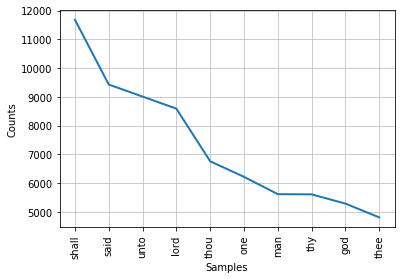

In [20]:
# top 10 most common words

freqdist.plot(10)
plt.show()

## Bag of words

In [21]:
def check_author(vocab):
    check = [False if author not in vocab else True 
             for author in np.unique(authors)]
    print(check)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# create a count vectorizer object
count_vectorizer = CountVectorizer()
bow = count_vectorizer.fit_transform(df_new['Texts']).toarray()
bow.shape

(738, 41306)

In [23]:
# ensure that authors name have been removed
check_author(count_vectorizer.vocabulary_.keys())

[False, False, False, False, False, False, False, False, False, False, False, False]


### Train-test split

In [24]:
from sklearn.model_selection import train_test_split
x = bow
y = df_new['Authors']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Decision tree

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

param_grid = [{'min_samples_split':[2, 5, 10, 20, 200]}]

tree_bow = GridSearchCV(estimator=DecisionTreeClassifier(random_state= 42), param_grid=param_grid, 
                        scoring='f1_micro', cv=4, n_jobs=-1)
tree_bow.fit(x_train, y_train)
print(tree_bow.best_params_)

# classification report
tree_bow_best = tree_bow.best_estimator_
print(classification_report(y_test, tree_bow_best.predict(x_test)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_split': 2}
              precision    recall  f1-score   support

      austen       0.93      0.84      0.88        31
       bible       1.00      1.00      1.00         5
       blake       1.00      0.75      0.86         8
      bryant       0.56      0.45      0.50        11
     burgess       0.43      0.60      0.50         5
     carroll       1.00      1.00      1.00         7
  chesterton       0.71      0.92      0.80        26
   edgeworth       0.67      0.86      0.75         7
    melville       1.00      0.78      0.88         9
      milton       1.00      0.67      0.80         6
 shakespeare       1.00      1.00      1.00        25
     whitman       1.00      0.88      0.93         8

   micro avg       0.84      0.84      0.84       148
   macro avg       0.86      0.81      0.82       148
weighted avg       0.87      0.84      0.85       148



### Multinomial NB

In [26]:
from sklearn.naive_bayes import MultinomialNB

param_grid = [{"alpha": np.arange(0.01, 0.1, 0.01)}]

mnb_bow = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring = 'neg_log_loss', cv = 4, n_jobs=-1)
mnb_bow.fit(x_train, y_train)
print(mnb_bow.best_params_)

#classification report
mnb_bow_best = mnb_bow.best_estimator_
print(classification_report(y_test, mnb_bow_best.predict(x_test)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.03}
              precision    recall  f1-score   support

      austen       1.00      1.00      1.00        31
       bible       1.00      1.00      1.00         5
       blake       1.00      1.00      1.00         8
      bryant       1.00      1.00      1.00        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       1.00      1.00      1.00        26
   edgeworth       1.00      1.00      1.00         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       1.00      1.00      1.00        25
     whitman       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [10, 30, 50, 70, 100]}

rfc_bow = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, scoring='f1_micro', cv=4, n_jobs=-1)
rfc_bow.fit(x_train, y_train)
print(rfc_bow.best_params_)

#classification report
rfc_bow_best = rfc_bow.best_estimator_
print(classification_report(y_test, rfc_bow_best.predict(x_test)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 70}
              precision    recall  f1-score   support

      austen       0.88      0.97      0.92        31
       bible       1.00      1.00      1.00         5
       blake       1.00      1.00      1.00         8
      bryant       1.00      0.45      0.62        11
     burgess       0.83      1.00      0.91         5
     carroll       0.78      1.00      0.88         7
  chesterton       0.83      0.96      0.89        26
   edgeworth       1.00      0.43      0.60         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       1.00      1.00      1.00        25
     whitman       1.00      1.00      1.00         8

   micro avg       0.92      0.92      0.92       148
   macro avg       0.94      0.90      0.90       148
weighted avg       0.93      0.92      0.91       148



### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]}

lr_bow = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='f1_micro', cv=4, n_jobs=-1)
lr_bow.fit(x_train, y_train)
print(lr_bow.best_params_)

#classification report
lr_bow_best = lr_bow.best_estimator_
print(classification_report(y_test, lr_bow_best.predict(x_test)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'C': 0.01}
              precision    recall  f1-score   support

      austen       1.00      0.97      0.98        31
       bible       1.00      1.00      1.00         5
       blake       1.00      1.00      1.00         8
      bryant       1.00      0.82      0.90        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       0.93      1.00      0.96        26
   edgeworth       1.00      1.00      1.00         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       0.96      1.00      0.98        25
     whitman       1.00      1.00      1.00         8

   micro avg       0.98      0.98      0.98       148
   macro avg       0.99      0.98      0.99       148
weighted avg       0.98      0.98      0.98       148



### KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [1,5,10]}

knn_bow = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
knn_bow.fit(x_train, y_train)

print(knn_bow.best_params_)

knn_bow_best = knn_bow.best_estimator_
print(classification_report(y_test, knn_bow_best.predict(x_test)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 1}
              precision    recall  f1-score   support

      austen       0.91      0.94      0.92        31
       bible       0.83      1.00      0.91         5
       blake       0.00      0.00      0.00         8
      bryant       0.50      0.64      0.56        11
     burgess       0.42      1.00      0.59         5
     carroll       0.60      0.86      0.71         7
  chesterton       0.89      0.62      0.73        26
   edgeworth       0.36      0.71      0.48         7
    melville       1.00      0.78      0.88         9
      milton       0.75      0.50      0.60         6
 shakespeare       0.89      0.64      0.74        25
     whitman       0.60      0.38      0.46         8

   micro avg       0.69      0.69      0.69       148
   macro avg       0.65      0.67      0.63       148
weighted avg       0.74      0.69      0.70       148



### Testing model

In [30]:
bag_test = ['''Him, also, by a curious coincidence, the professor had not
invented, and him he had not even very greatly improved, though
he had fished him up with a lasso out of his own back garden, in
Western Bulgaria''',
            
           '''That were the Slaues of drinke, and thralles of sleepe?
Was not that Nobly done?''',
            
           '''About 17OO years ago, during the reign of the Roman Emperor Titus, there
happened a terrible eruption of Mount Vesuvius;''', 
           '''Piper, sit thee down and write
   In a book, that all may read.''',
            
           '''A flower was offered to me,
   Such a flower as May never bore;''',
            
           'She ceasd & smild in tears, then sat down in her silver shrine.']

In [119]:
bag_test_label = ['chesterton', 'shakespeare',
                  'edgeworth', 'blake',
                  'blake', 'blake']

bag_test_transform = count_vectorizer.transform(bag_test)

print(mnb_bow_best.predict(bag_test_transform))
mnb_bow_best.score(bag_test_transform, bag_test_label)

['chesterton' 'shakespeare' 'edgeworth' 'blake' 'blake' 'blake']


1.0

In [117]:
print(lr_bow_best.predict(bag_test_transform))
lr_bow_best.score(bag_test_transform, bag_test_label)

['chesterton' 'blake' 'blake' 'blake' 'blake' 'blake']


0.6666666666666666

## TF-IDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer("english")
tfidf = tfidf_vectorizer.fit_transform(df_new['Texts']).toarray()
tfidf.shape

(738, 41306)

In [33]:
# ensure that authors name have been removed
check_author(tfidf_vectorizer.vocabulary_.keys())

[False, False, False, False, False, False, False, False, False, False, False, False]


### Train-test split

In [122]:
x = tfidf
y = df_new['Authors']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

### Decision tree

In [123]:
param_grid = [{'min_samples_split':[2, 5, 10, 20, 50]}]

tree_tfidf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
tree_tfidf.fit(x_train1, y_train1)

print(tree_tfidf.best_params_)

tree_tfidf_best = tree_tfidf.best_estimator_
print(classification_report(y_test1, tree_tfidf_best.predict(x_test1)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_split': 2}
              precision    recall  f1-score   support

      austen       0.86      0.81      0.83        31
       bible       1.00      1.00      1.00         5
       blake       0.67      0.50      0.57         8
      bryant       0.55      0.55      0.55        11
     burgess       1.00      0.80      0.89         5
     carroll       0.83      0.71      0.77         7
  chesterton       0.65      0.85      0.73        26
   edgeworth       0.70      1.00      0.82         7
    melville       1.00      0.89      0.94         9
      milton       1.00      0.67      0.80         6
 shakespeare       1.00      0.96      0.98        25
     whitman       0.86      0.75      0.80         8

   micro avg       0.81      0.81      0.81       148
   macro avg       0.84      0.79      0.81       148
weighted avg       0.83      0.81      0.81       148



### Multinomial NB 

In [124]:
param_grid = [{"alpha": np.arange(0.001, 0.01, 0.001)}]

mnb_tfidf = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring = 'neg_log_loss', cv = 4, n_jobs=-1)
mnb_tfidf.fit(x_train1, y_train1)
print(mnb_tfidf.best_params_)

mnb_tfidf_best = mnb_tfidf.best_estimator_
print(classification_report(y_test1, mnb_tfidf_best.predict(x_test1)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.003}
              precision    recall  f1-score   support

      austen       1.00      1.00      1.00        31
       bible       1.00      1.00      1.00         5
       blake       1.00      1.00      1.00         8
      bryant       1.00      1.00      1.00        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       1.00      1.00      1.00        26
   edgeworth       1.00      1.00      1.00         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       1.00      1.00      1.00        25
     whitman       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



### Random Forest

In [125]:
param_grid = {'n_estimators': [30, 50, 70, 100, 200]}

rfc_tfidf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
rfc_tfidf.fit(x_train1, y_train1)

print(rfc_tfidf.best_params_)

rfc_tfidf_best = rfc_tfidf.best_estimator_
print(classification_report(y_test1, rfc_tfidf_best.predict(x_test1)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 100}
              precision    recall  f1-score   support

      austen       1.00      0.97      0.98        31
       bible       1.00      1.00      1.00         5
       blake       0.88      0.88      0.88         8
      bryant       0.82      0.82      0.82        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       0.93      0.96      0.94        26
   edgeworth       1.00      1.00      1.00         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       1.00      1.00      1.00        25
     whitman       1.00      1.00      1.00         8

   micro avg       0.97      0.97      0.97       148
   macro avg       0.97      0.97      0.97       148
weighted avg       0.97      0.97      0.97       148



### Logistic Regression

In [126]:
param_grid = {'C': [0.0001,0.001,0.01,0.1,1,10]}

lr_tfidf = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
lr_tfidf.fit(x_train1, y_train1)

print(lr_tfidf.best_params_)

lr_tfidf_best = lr_tfidf.best_estimator_
print(classification_report(y_test1, lr_tfidf_best.predict(x_test1)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'C': 10}
              precision    recall  f1-score   support

      austen       1.00      0.97      0.98        31
       bible       1.00      1.00      1.00         5
       blake       1.00      1.00      1.00         8
      bryant       1.00      0.91      0.95        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       0.96      1.00      0.98        26
   edgeworth       1.00      1.00      1.00         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       0.96      1.00      0.98        25
     whitman       1.00      1.00      1.00         8

   micro avg       0.99      0.99      0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148



### KNN

In [127]:
param_grid = {'n_neighbors': [1,5,10,20]}

knn_tfidf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
knn_tfidf.fit(x_train1, y_train1)

print(knn_tfidf.best_params_)

knn_tfidf_best = knn_tfidf.best_estimator_
print(classification_report(y_test1, knn_tfidf_best.predict(x_test1)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 1}
              precision    recall  f1-score   support

      austen       1.00      1.00      1.00        31
       bible       1.00      1.00      1.00         5
       blake       1.00      1.00      1.00         8
      bryant       1.00      1.00      1.00        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       1.00      1.00      1.00        26
   edgeworth       1.00      1.00      1.00         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       1.00      1.00      1.00        25
     whitman       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



### Testing model

In [141]:
tfidf_test_transform = tfidf_vectorizer.transform(bag_test)

print(mnb_tfidf_best.predict(tfidf_test_transform))
mnb_tfidf_best.score(bag_test_transform, bag_test_label)

['chesterton' 'shakespeare' 'edgeworth' 'bible' 'blake' 'blake']


0.8333333333333334

In [148]:
print(lr_tfidf_best.predict(tfidf_test_transform))
lr_tfidf_best.score(bag_test_transform, bag_test_label)

['chesterton' 'shakespeare' 'shakespeare' 'blake' 'blake' 'blake']


0.6666666666666666

## Word2Vec 

### Preprocess

In [40]:
from gensim.models import Word2Vec, Doc2Vec

In [41]:
df_vec = df_new.Texts.apply(lambda x: x.split(' '))

# create model
w2v_model = Word2Vec(df_vec, min_count=1, window=3, size=300, sg=1)

In [42]:
# ensure that authors name have been removed
check_author(list(w2v_model.wv.vocab))

[False, False, False, False, False, False, False, False, False, False, False, False]


In [153]:
# compute sentence to vectors
def compute_average(df_vec):
    doc_vec = pd.DataFrame()
    for examples in df_vec:
        temp = np.zeros([1,300])
        for word in examples:
            word_vec = w2v_model[word].reshape(1,-1)
            temp = temp + word_vec
        temp = np.mean(temp, axis=0, keepdims=True)
        doc_vec = doc_vec.append(pd.Series(np.ravel(temp)), ignore_index=True)    
    
    return doc_vec

doc_vec = compute_average(df_vec)
doc_vec.shape

C:\Users\tqnha\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(738, 300)

In [44]:
# get vectors from sentence by gensim

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_vec)]
model_w2v = Doc2Vec(documents, vector_size=300, window=3, min_count=1, workers=4)

# w2v_vec = []
# for sent in df_vec:
#     sent_vec = model_w2v.infer_vector(sent)
#     w2v_vec.append(sent_vec)
    
# w2v_vec = np.asarray(w2v_vec)

### Train-test spit

In [129]:
x = doc_vec
y = df_new['Authors']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.2, random_state=42)

### Decision tree

In [130]:
param_grid = [{'min_samples_split':[2, 5, 10, 20, 50]}]

tree_w2v = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, 
                        scoring='f1_weighted', cv=4, n_jobs=-1)
tree_w2v.fit(x_train2, y_train2)

print(tree_w2v.best_params_)

tree_w2v_best = tree_w2v.best_estimator_
print(classification_report(y_test2, tree_w2v_best.predict(x_test2)))

{'min_samples_split': 2}
              precision    recall  f1-score   support

      austen       1.00      1.00      1.00        31
       bible       1.00      0.80      0.89         5
       blake       1.00      0.88      0.93         8
      bryant       0.85      1.00      0.92        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      0.86      0.92         7
  chesterton       1.00      1.00      1.00        26
   edgeworth       1.00      1.00      1.00         7
    melville       0.90      1.00      0.95         9
      milton       0.62      0.83      0.71         6
 shakespeare       1.00      0.88      0.94        25
     whitman       0.78      0.88      0.82         8

   micro avg       0.95      0.95      0.95       148
   macro avg       0.93      0.93      0.92       148
weighted avg       0.96      0.95      0.95       148



C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Multinomial NB

In [131]:
from sklearn.naive_bayes import GaussianNB
param_grid = [{"var_smoothing": np.arange(1e-5, 1e-4, 1e-3)}]

# gridsearch object using 4 fold cross validation and neg_log_loss as scoring paramter
mnb_w2v = GridSearchCV(GaussianNB(), param_grid=param_grid, scoring = 'neg_log_loss', cv = 4, n_jobs=-1)
# fit the gridsearch
mnb_w2v.fit(x_train2, y_train2)
print(mnb_w2v.best_params_)

mnb_w2v_best = mnb_w2v.best_estimator_
print(classification_report(y_test2, mnb_w2v_best.predict(x_test2)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'var_smoothing': 1e-05}
              precision    recall  f1-score   support

      austen       1.00      0.97      0.98        31
       bible       1.00      1.00      1.00         5
       blake       0.67      1.00      0.80         8
      bryant       1.00      1.00      1.00        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       1.00      0.96      0.98        26
   edgeworth       1.00      1.00      1.00         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       1.00      0.92      0.96        25
     whitman       1.00      1.00      1.00         8

   micro avg       0.97      0.97      0.97       148
   macro avg       0.97      0.99      0.98       148
weighted avg       0.98      0.97      0.98       148



### Random Forest

In [132]:
param_grid = {'n_estimators': [30, 50, 70, 100, 200]}

rfc_w2v = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
rfc_w2v.fit(x_train2, y_train2)

print(rfc_w2v.best_params_)

rfc_w2v_best = rfc_w2v.best_estimator_
print(classification_report(y_test2, rfc_w2v_best.predict(x_test2)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 100}
              precision    recall  f1-score   support

      austen       1.00      1.00      1.00        31
       bible       1.00      1.00      1.00         5
       blake       1.00      0.88      0.93         8
      bryant       1.00      1.00      1.00        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       1.00      1.00      1.00        26
   edgeworth       0.88      1.00      0.93         7
    melville       1.00      1.00      1.00         9
      milton       0.86      1.00      0.92         6
 shakespeare       1.00      0.96      0.98        25
     whitman       1.00      1.00      1.00         8

   micro avg       0.99      0.99      0.99       148
   macro avg       0.98      0.99      0.98       148
weighted avg       0.99      0.99      0.99       148



### Logistic Regression

In [133]:
param_grid = {'C': [0.01,0.1,1,10,20]}

lr_w2v = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='neg_log_loss', cv=4, n_jobs=-1)
lr_w2v.fit(x_train2, y_train2)

print(lr_w2v.best_params_)

lr_w2v_best = lr_w2v.best_estimator_
print(classification_report(y_test2, lr_w2v_best.predict(x_test2)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'C': 0.01}
              precision    recall  f1-score   support

      austen       1.00      0.97      0.98        31
       bible       1.00      1.00      1.00         5
       blake       0.88      0.88      0.88         8
      bryant       1.00      0.82      0.90        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       1.00      1.00      1.00        26
   edgeworth       0.70      1.00      0.82         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       1.00      1.00      1.00        25
     whitman       1.00      1.00      1.00         8

   micro avg       0.97      0.97      0.97       148
   macro avg       0.96      0.97      0.97       148
weighted avg       0.98      0.97      0.97       148



C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### KNN

In [134]:
param_grid = {'n_neighbors': [1,5,10,20]}

knn_w2v = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
knn_w2v.fit(x_train2, y_train2)

print(knn_w2v.best_params_)

knn_w2v_best = knn_w2v.best_estimator_
print(classification_report(y_test2, knn_w2v_best.predict(x_test2)))

{'n_neighbors': 5}
              precision    recall  f1-score   support

      austen       1.00      1.00      1.00        31
       bible       1.00      1.00      1.00         5
       blake       1.00      0.88      0.93         8
      bryant       0.79      1.00      0.88        11
     burgess       1.00      1.00      1.00         5
     carroll       1.00      1.00      1.00         7
  chesterton       1.00      1.00      1.00        26
   edgeworth       1.00      1.00      1.00         7
    melville       1.00      1.00      1.00         9
      milton       1.00      1.00      1.00         6
 shakespeare       1.00      0.92      0.96        25
     whitman       1.00      1.00      1.00         8

   micro avg       0.98      0.98      0.98       148
   macro avg       0.98      0.98      0.98       148
weighted avg       0.98      0.98      0.98       148



C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### SVM

In [135]:
from sklearn import svm

param_grid = {'C' : [1e-2,1e-1,1,10,100],
              'gamma' : [1e-2,1e-1,1,10]}

svm_w2v = GridSearchCV(svm.SVC(kernel='rbf'), param_grid=param_grid, scoring='f1_weighted', cv=4, n_jobs=-1)
svm_w2v.fit(x_train2, y_train2)

print(svm_w2v.best_params_)

#classification report
svm_w2v_best = svm_w2v.best_estimator_
print(classification_report(y_test2, svm_w2v_best.predict(x_test2)))

C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'gamma': 0.01}
              precision    recall  f1-score   support

      austen       1.00      0.03      0.06        31
       bible       0.00      0.00      0.00         5
       blake       0.00      0.00      0.00         8
      bryant       0.00      0.00      0.00        11
     burgess       0.00      0.00      0.00         5
     carroll       0.00      0.00      0.00         7
  chesterton       1.00      0.04      0.07        26
   edgeworth       0.00      0.00      0.00         7
    melville       0.00      0.00      0.00         9
      milton       0.00      0.00      0.00         6
 shakespeare       0.17      1.00      0.29        25
     whitman       0.00      0.00      0.00         8

   micro avg       0.18      0.18      0.18       148
   macro avg       0.18      0.09      0.04       148
weighted avg       0.41      0.18      0.08       148



C:\Users\tqnha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## RNN 

In [52]:
from __future__ import print_function
import keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used. (most frequent)
MAX_WORDS = 50000
# Max number of words in each examples.
EMBEDDING_DIM = 300

Using TensorFlow backend.


### Preprocess data

In [53]:
# split documents to have more training examples

df_new1 = split_sample(df, 1900)
df_new1

,Novels,Texts,Authors,Target
0,emma,emma jane volume chapter emma woodhouse handso...,austen,0
1,emma,marriage mistress house early period mother di...,austen,0
2,emma,emma intimacy sisters even miss taylor ceased ...,austen,0
3,emma,chiefly real evils indeed emma situation power...,austen,0
4,emma,taylor married miss taylor loss first brought ...,austen,0
...,...,...,...,...
35541,leaves,lighting light sky stars delving earth sailing...,whitman,11
35542,leaves,square cubic inch germinal exquisite delicate ...,whitman,11
35543,leaves,forming endless waiting ever forever behind go...,whitman,11
35544,leaves,nightfall soon heart thud stopping long lived ...,whitman,11


In [54]:
tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_new1.Texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df_new1.Texts)
X = pad_sequences(X, maxlen=50, padding='post', truncating='post')
print('Shape of X:', X.shape)

Y = df_new1.Target
print('Shape of Y:', Y.shape)

Found 41323 unique tokens.
Shape of X: (35546, 50)
Shape of Y: (35546,)


In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
Y_train = keras.utils.to_categorical(Y_train)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(28436, 50) (28436, 12)
(7110, 50) (7110,)


### Training

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, SpatialDropout1D, LSTM

model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=300, input_length=X.shape[1]))

model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, activation='tanh'))
model.add(Dropout(0.6))

model.add(Dense(12, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(lr=0.001, decay=1e-4), 
              metrics=['accuracy'])

In [57]:
epochs = 20
batch_size = 1024

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.1)

C:\Users\tqnha\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25592 samples, validate on 2844 samples
Epoch 1/20
25592/25592 [==============================] - 65s 3ms/step - loss: 1.9169 - accuracy: 0.3135 - val_loss: 1.1980 - val_accuracy: 0.4887
Epoch 2/20
25592/25592 [==============================] - 65s 3ms/step - loss: 1.0449 - accuracy: 0.5416 - val_loss: 0.7670 - val_accuracy: 0.6449
Epoch 3/20
25592/25592 [==============================] - 66s 3ms/step - loss: 0.6608 - accuracy: 0.7022 - val_loss: 0.5243 - val_accuracy: 0.7602
Epoch 4/20
25592/25592 [==============================] - 66s 3ms/step - loss: 0.4582 - accuracy: 0.7883 - val_loss: 0.5270 - val_accuracy: 0.7729
Epoch 5/20
25592/25592 [==============================] - 67s 3ms/step - loss: 0.3255 - accuracy: 0.8614 - val_loss: 0.4475 - val_accuracy: 0.8298
Epoch 6/20
25592/25592 [==============================] - 67s 3ms/step - loss: 0.1946 - accuracy: 0.9340 - val_loss: 0.4701 - val_accuracy: 0.8442
Epoch 7/20
25592/25592 [==============================] - 65s 3ms/ste

In [58]:
predict_test_labels = np.argmax(model.predict(X_test), axis=1)
actual_test_labels = Y_test

print(classification_report(Y_test, predict_test_labels ))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1171
           1       0.98      1.00      0.99       383
           2       0.98      0.96      0.97       457
           3       0.89      0.96      0.92       364
           4       0.81      0.86      0.83       446
           5       0.69      0.84      0.76       438
           6       0.96      0.91      0.93      1145
           7       0.92      0.95      0.93       375
           8       1.00      0.95      0.97       369
           9       0.90      0.93      0.91       358
          10       0.89      0.81      0.85      1217
          11       0.96      0.92      0.94       387

   micro avg       0.91      0.91      0.91      7110
   macro avg       0.91      0.92      0.91      7110
weighted avg       0.91      0.91      0.91      7110



## Topic modelling

In [253]:
# print out 10 topic

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

no_topics = 10
no_top_words = 10

def display_topics(model, vocab, no_top_words):
    topic_list = []
    for idx, topic in enumerate(model.components_):
        top = " ".join([vocab[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(f'Topic {idx+1}: {top}')
        print()
    
        topic_list.append(top)
        
    return topic_list

### NMF

In [254]:
# Run NMF
nmf = NMF(n_components=no_topics, random_state=42, alpha=0.1).fit(tfidf)
nmf.components_.shape

(10, 41306)

In [255]:
topic_nmf = display_topics(nmf, tfidf_vectorizer.get_feature_names(), no_top_words)

Topic 1: emma mr harriet mrs weston knightley elton miss woodhouse jane

Topic 2: unto lord shall ye thou israel thy god thee king

Topic 3: turnbull syme said macian man like one professor evan face

Topic 4: haue ham caesar bru brutus vs macb lord thou cassi

Topic 5: elinor marianne mrs edward willoughby jennings dashwood lucy sister could

Topic 6: buster joe bear farmer little brown boy blacky otter forest

Topic 7: whale ahab ship boat whales stubb sperm one ye sea

Topic 8: anne elliot wentworth captain mrs charles russell could musgrove mary

Topic 9: alice said queen little rabbit hatter duchess gryphon turtle mouse

Topic 10: thy thou thee heaven earth thus shall god love yet



### LSA

In [256]:
svd = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10).fit(tfidf)
svd.components_.shape

(10, 41306)

In [257]:
topic_svd = display_topics(svd, tfidf_vectorizer.get_feature_names(), no_top_words)

Topic 1: said mrs mr one could would shall unto man thou

Topic 2: unto thou thy lord thee shall ye god israel hath

Topic 3: turnbull syme said macian alice whale buster like brown little

Topic 4: haue ham caesar bru brutus macb vs cassi vpon enter

Topic 5: elinor marianne edward willoughby jennings dashwood lucy sister brandon ferrars

Topic 6: buster joe bear farmer little elinor brown marianne otter blacky

Topic 7: whale buster ahab joe captain ship bear anne whales boat

Topic 8: anne elliot alice captain wentworth charles russell mary musgrove louisa

Topic 9: alice whale queen ahab hatter duchess rabbit gryphon said turtle

Topic 10: whale unto lord ahab ham ye whales ship syme sperm



### LDA sklearn

### LDA gensim

In [258]:
from gensim.models.ldamodel import LdaModel
from gensim import corpora

# get word and id of word
id2word = corpora.Dictionary(df_vec)

# get id of word and its B.O.W 
corpus = [id2word.doc2bow(word) for word in df_vec]

In [259]:
# train lda model
lda_model = LdaModel(corpus=corpus, num_topics=no_topics, 
                    id2word=id2word, passes=15)

In [260]:
# print out 10 topics
for i, topic in lda_model.show_topics(formatted=False):
    print(f'Topic {i+1}: {[w[0] for w in topic]}')
    print()

Topic 1: ['shall', 'unto', 'moses', 'lord', 'offering', 'upon', 'children', 'thou', 'aaron', 'made']

Topic 2: ['said', 'little', 'one', 'know', 'could', 'would', 'like', 'syme', 'upon', 'good']

Topic 3: ['see', 'thee', 'love', 'life', 'one', 'earth', 'old', 'day', 'yet', 'soul']

Topic 4: ['could', 'would', 'mr', 'one', 'mrs', 'said', 'must', 'much', 'well', 'every']

Topic 5: ['haue', 'ham', 'thou', 'lord', 'shall', 'enter', 'king', 'come', 'good', 'let']

Topic 6: ['whale', 'one', 'ship', 'ahab', 'like', 'ye', 'upon', 'sea', 'man', 'old']

Topic 7: ['said', 'like', 'man', 'one', 'turnbull', 'macian', 'heaven', 'brown', 'little', 'face']

Topic 8: ['shall', 'god', 'thou', 'unto', 'thy', 'ye', 'lord', 'man', 'thee', 'hath']

Topic 9: ['unto', 'lord', 'shall', 'said', 'thou', 'thy', 'thee', 'king', 'god', 'israel']

Topic 10: ['shall', 'unto', 'lord', 'ye', 'offering', 'thou', 'upon', 'thy', 'priest', 'land']



In [261]:
# evaluate lda model by perplexity
lda_model.log_perplexity(corpus)

-7.986477071885339

In [262]:
# evaluate lda model by oherence score
from gensim.models.coherencemodel import CoherenceModel

coherence_lda = CoherenceModel(model=lda_model, texts=df_vec, coherence='c_v')
coherence_lda.get_coherence()

0.483518724782878

In [263]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
lda_vis

C:\Users\tqnha\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.151224  0.030986       1        1  25.093439
8      0.178954  0.040057       2        1  21.082071
7      0.092411  0.012546       3        1  13.979059
1     -0.139809  0.043455       4        1  10.290544
6     -0.141818  0.056033       5        1   9.026441
5     -0.113350  0.046713       6        1   7.608554
2     -0.081808  0.015112       7        1   6.109668
4     -0.044820 -0.269006       8        1   3.164733
9      0.196449  0.010192       9        1   1.828311
0      0.205017  0.013912      10        1   1.817185, topic_info=      Category          Freq    Term         Total  loglift  logprob
680    Default  11106.000000   shall  11106.000000  30.0000  30.0000
10756  Default   8638.000000    unto   8638.000000  29.0000  29.0000
2581   Default   8211.000000    lord   8211.000000  28.0000  28.0000
5503   Default   6534.000000    thou   6534.000000  27.0000  27.0000
3230   Default   4544.000000      ye   4544.000000  26.0000  26.0000
...        ...           ...     ...           ...      ...      ...
464    Topic10     90.666328    make   2153.333008   0.8403  -5.3255
547    Topic10    113.552979     one   6015.055664   0.0381  -5.1004
11033  Topic10     83.249153  israel   2457.239746   0.6229  -5.4108
3230   Topic10     80.265282      ye   4544.128418  -0.0284  -5.4473
4063   Topic10     76.862587     god   5167.294434  -0.2002  -5.4907

[836 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
10813      2  0.226433        aaron
10813      3  0.026253        aaron
10813      5  0.003282        aaron
10813      9  0.154237        aaron
10813     10  0.587413        aaron
...      ...       ...          ...
859       10  0.005056          yet
28315      6  0.941271         yojo
14166      2  0.977267     zedekiah
12045      9  0.781351         zuar
12047      9  0.781184  zurishaddai

[2732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 8, 2, 7, 6, 3, 5, 10, 1])